In [26]:
"""Import Necessary Libraries"""
from keras.layers import Conv2D, Dense, merge,Lambda,Input, MaxPooling2D,Lambda,Flatten
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy

import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import sys
from scipy.misc import imread

%matplotlib inline

In [27]:
"""Preprocess the omniglot dataset and pickle it into an array that's easy
    to index my character type."""

path = "./"
save = os.getcwd()
data_path = os.path.join(path, "python")
train_folder = os.path.join(path,'images_background')
val_folder = os.path.join(path,'images_evaluation')

save_path = save
lang_dict = {}

def loadimgs(path,n=0):
    # If data not already unzipped, unzip it.
    if not os.path.exists(path):
        print("unzipping")
        os.chdir(data_path)
        os.system("unzip {}".format(path+".zip" ))

    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n

    # Load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)

        # Every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # Every column has 20 images, finally load the images in an array.
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # Edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    
    # Stack all targets and inputs into 1 variable each.
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

In [28]:
#Dump stacked input images in pickle files
X,y,c=loadimgs(train_folder)
with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X,c),f)

X,y,c=loadimgs(val_folder)
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((X,c),f)

unzipping
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Anglo-Saxon_Futhorc


C:\Users\sbpat\AppData\Local\Continuum\anaconda3\envs\DLENV\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


loading alphabet: Arcadian
loading alphabet: Armenian
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Balinese
loading alphabet: Bengali
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Braille
loading alphabet: Burmese_(Myanmar)
loading alphabet: Cyrillic
loading alphabet: Early_Aramaic
loading alphabet: Futurama
loading alphabet: Grantha
loading alphabet: Greek
loading alphabet: Gujarati
loading alphabet: Hebrew
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Japanese_(hiragana)
loading alphabet: Japanese_(katakana)
loading alphabet: Korean
loading alphabet: Latin
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: N_Ko
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Sanskrit
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Tagalog
loading alphabet: Tifinagh
loading alphabet: Angelic
loading alphabet: Atemayar_Qelisayer
loading alphabet:

In [49]:
os.getcwd()

'F:\\Co-Curriculars\\DEEP LEARNING\\FELLOWSHIP AI\\keras-oneshot-master'

In [48]:
os.chdir("..")

In [29]:
"""Define Custom Initializers as described in the paper by Univerity of Toronto"""
# Siamese Neural Networks for One-shot Image Recognition, Gregory Koch et al., 2015, ICML
# These initializers would be used to initialize kernel and bias weights in convolutional layers
def w_init(shape,name=None):
    values = np.random.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)

def b_init(shape,name=None):
    values = np.random.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

In [30]:
"""Construct the model"""
"""This model was proposed in the paper. I tried a bunch of other models, increasing complexity and no. of layers, but it 
increased training time drastically without much improvement over validation accuracy. 
This model did fit the best with minimum amount of time.

Hence, for the submission, I'm keeping the original model only. I will keep
experimenting with others in the meanwhile."""

# Omniglot data is of shape (105,105) and greyscale. 
input_shape = (105,105,1)
upper_ip = Input(input_shape)
lower_ip = Input(input_shape)

# Create a standard CNN model connected to a 4096 FC layer
model = Sequential()
model.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                kernel_initializer = w_init,kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=w_init,bias_initializer=b_init))
model.add(MaxPooling2D())
model.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=w_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
model.add(MaxPooling2D())
model.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=w_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
model.add(Flatten())
model.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=w_init,bias_initializer=b_init))

# Initialize the model twice for the 2 brances of the siamese network.
encoded_up = model(upper_ip)
encoded_down = model(lower_ip)

# Calculate L1 distance between the two flattened layers
merge = Lambda(lambda layers:K.abs(layers[0]-layers[1]))
merge_distance = merge([encoded_up,encoded_down])

# Define Last layer which connects 4096 dense layer to a single output node
# with sigmoid activation to give output 0 or 1
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(merge_distance)

# Create Siamese CNN with 2 inputs and 1 output.
siamese = Model(inputs=[upper_ip,lower_ip],outputs=prediction)

# Define learning rate and optimizer.
learning_rate = 1e-5
optimizer = Adam(learning_rate)

# Compile the model
siamese.compile(loss='binary_crossentropy',optimizer = optimizer)

In [31]:
# Check no. of paramters to be trained.
siamese.count_params()

38951745

In [50]:
"""Load pickled data from train.pickle and val.pickle"""

path = "./"
with open(os.path.join(path,"train.pickle"),'rb') as f:
    (x,c) = pickle.load(f)

with open(os.path.join(path,"val.pickle"),"rb") as f:
    (xval,cval) = pickle.load(f)
    
print("Background",c.keys())
print("Evaluation",cval.keys())

Background dict_keys(['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh'])
Evaluation dict_keys(['Angelic', 'Atemayar_Qelisayer', 'Atlantean', 'Aurek-Besh', 'Avesta', 'Ge_ez', 'Glagolitic', 'Gurmukhi', 'Kannada', 'Keble', 'Malayalam', 'Manipuri', 'Mongolian', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Sylheti', 'Syriac_(Serto)', 'Tengwar', 'Tibetan', 'ULOG'])


In [51]:
"""Load data and their category into dictionaries and define functions"""
class Siamese_Net:
    # Load batches and testing tasks to a siamese network
    def __init__(self,path,data_subsets=['train','val']):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path,name+".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (x,c) = pickle.load(f)
                self.data[name]=x
                self.categories[name]=c
    
    # Return `batch_size` number of input pairs and targets for training purposes            
    def get_batch(self,batch_size,s="train"):
        # Create batch of n pais, half same class, half different class to train network
        x = self.data[s]
        n_classes,n_examples,w,h = x.shape
        
        # Randomly sample several classes to use in the batch
        categories = np.random.choice(n_classes,size=(batch_size,),replace=False)
        
        # Initialize 2 empty arrays for ip image batch
        pairs = [np.zeros((batch_size, h, w, 1)) for i in range(2)]
        
        # Init vector for targets and make 1 half of it '1's, so 2nd half of batch has same class
        targets = np.zeros((batch_size,))
        targets[batch_size//2:]=1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = np.random.randint(0,n_examples)
            pairs[0][i,:,:,:] = x[category,idx_1].reshape(w,h,1)
            idx_2 = np.random.randint(0,n_examples)
            
            # Choose same class images for 1st half, different for 2nd half
            if i>=batch_size//2:
                category_2 = category
            else:
                # Add a random no. to the category modulo n classes to ensure different category
                category_2 = (category+np.random.randint(1,n_classes))%n_classes
            pairs[1][i,:,:,:] = x[category_2,idx_2].reshape(w,h,1)
        return pairs,targets
    
    # Generate a bunch of pairs and targets and send them to the training loop
    def generate(self,batch_size, s='train'):
        while True:
            pairs,targets = self.get_batch(batch_size,s)
            yield (pairs,targets)
    
    # Generate input pairs and targets for validation and testing purposes
    def make_oneshot_task(self,N,s='val',language=None):
        X = self.data[s]
        n_classes,n_examples,w,h = X.shape
        indices = np.random.randint(0,n_examples,size=(N,))
        if language is not None:
            low,high = self.categories[s][language]
            if N>high-low:
                raise ValueError("This language ({}) has less than {} letters").format(language,N)
            categories = np.random.choice(range(low,high),size=(N,),replace=False)
            
        else:
            # If no language specified, pick a bunch of random letters
            categories = np.random.choice(range(n_classes),size=(N,),replace=False)
        true_category = categories[0]
        
        ex1,ex2 = np.random.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N,w,h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N,w,h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets,test_image,support_set = shuffle(targets,test_image,support_set)
        pairs = [test_image,support_set]
        
        return pairs,targets
   
    # Generate testing pairs and targets and pass them through the model to get accuracy
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            ips, tgts = self.make_oneshot_task(N,s)
            probs = model.predict(ips)
            if np.argmax(probs) == np.argmax(tgts):
                n_correct+=1
        accuracy = (100.0*n_correct/k)
        if verbose:
            print("Got an avg of {}% {} way one-shot learning accuracy".format(accuracy,N))
        return accuracy
    
    #training function 
    def train(self,model,epochs,verbosity):
        model.fit_generator(self.generate(batch_size))

In [52]:
"""Create an object of the Siamese_Net class to use its functions later"""
loader = Siamese_Net(path)

loading data from ./train.pickle
loading data from ./val.pickle


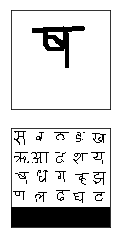

In [53]:
"""Code for representing validation cycle

1. A character is chosen at random. 
2. N different characters are paired with it in make_oneshot_task function
3. All the pairs are fit into a matrix and displayed."""
def concat_images(X):
    # Concatenate a bunch of images in a matrix to plot
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x=0
    y=0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y+=1
        if y >= n:
            y = 0
            x+=1
    return img

def plot_oneshot_task(pairs):
    # Take a one-shot task given to a siamese net 
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
pairs,targets = loader.make_oneshot_task(20,"train","Sanskrit")
plot_oneshot_task(pairs)

# In the current example, the letter matches with the 19th character, thus target value for 19th character will be 1
# For all others, it will be 0.

In [54]:
"""The model was trained with very low learning rate for 25000 epochs. It was stopped when validation accuracy crossed 94% threshold
    set by me. For submission, I have trained the model again for a few epochs to demonstrate its working."""
#Training loop
eval_every = 10 # Interval for evaluating one-shot tasks
loss_every = 50 # No. of epochs to print loss after
batch_size = 256 
epochs = 90000
N_way = 20 # Classes for testing one-shot tasks
n_val = 250 # No. of one-shot tasks to validate on
best = -1
weights_path = os.path.join(path,"weights")
print("training")
for i in range(1,epochs):
    # Get inputs and targets form training dataset
    (ips,tgts) = loader.get_batch(batch_size)
    
    #train the siamese model we created above on this batch
    loss = siamese.train_on_batch(ips,tgts)
    print(loss)
    
    # Evaluate performance on validation set every 10 epochs and save the weights if and only if current validation metrics
    # are better than all previous validation metrics. 
    if i%eval_every == 0:
        print("evaluating")
        val_acc = loader.test_oneshot(siamese,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("saving model")
            siamese.save(weights_path)
            best = val_acc
            
    # Display no. of epochs every 50 epochs and show loss at that step
    if i%loss_every == 0:
        print("Epoch {}, training loss: {:.2f},".format(i,loss))

training
4.5184593
4.504605
4.4932117
4.4786215
4.4624867
4.45266
4.4438763
4.4462686
4.4463387
4.4332027
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an avg of 35.2% 20 way one-shot learning accuracy
saving model
4.4300957
4.437707
4.417111
4.4189153
4.418826
4.4010015
4.392983
4.3916526
4.381467
4.380092
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...


KeyboardInterrupt: 

In [ ]:
# The code below this was executed on a well trained network with maximum of 94% accuracy. 
# Hence, I am not runnning the modules below for submission. But they have been run previously.

Evaluating model on 450 random 1 way one-shot learning tasks ...
Got an avg of 100.0% 1 way one-shot learning accuracy
Evaluating model on 450 random 1 way one-shot learning tasks ...
Got an avg of 100.0% 1 way one-shot learning accuracy
Evaluating model on 450 random 3 way one-shot learning tasks ...
Got an avg of 98.44444444444444% 3 way one-shot learning accuracy
Evaluating model on 450 random 3 way one-shot learning tasks ...
Got an avg of 100.0% 3 way one-shot learning accuracy
Evaluating model on 450 random 5 way one-shot learning tasks ...
Got an avg of 95.11111111111111% 5 way one-shot learning accuracy
Evaluating model on 450 random 5 way one-shot learning tasks ...
Got an avg of 99.55555555555556% 5 way one-shot learning accuracy
Evaluating model on 450 random 7 way one-shot learning tasks ...
Got an avg of 94.0% 7 way one-shot learning accuracy
Evaluating model on 450 random 7 way one-shot learning tasks ...
Got an avg of 99.55555555555556% 7 way one-shot learning accuracy
E

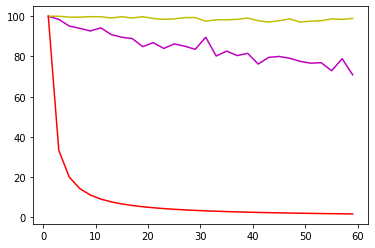

In [23]:
ways = np.arange(1, 60, 2)
resume =  False
val_accs, train_accs = [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(siamese, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(siamese, N,trials, "train", verbose=True))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")

plt.plot(ways,100.0/ways,"r")
plt.show()

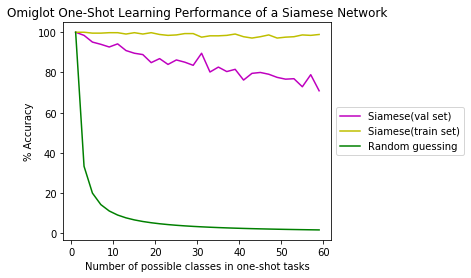

In [24]:
"""Plot the values from the training and validation sets to look at how the model performs on N different bunch of images."""
fig,ax = plt.subplots(1)
ax.plot(ways,val_accs,"m",label="Siamese(val set)")
ax.plot(ways,train_accs,"y",label="Siamese(train set)")

ax.plot(ways,100.0/ways,"g",label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20,"val")
plt.show()

(20, 105, 105, 1)


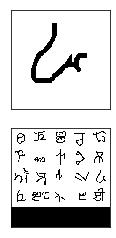

[[1.7006201e-04]
 [7.0032102e-06]
 [8.8159089e-07]
 [4.6345082e-07]
 [2.3051680e-03]
 [1.1227354e-05]
 [8.9493529e-05]
 [2.1000413e-05]
 [1.2000882e-04]
 [7.2259759e-06]
 [9.3690833e-06]
 [4.8009738e-08]
 [1.3810607e-03]
 [4.5574945e-04]
 [7.4376434e-01]
 [2.1682293e-03]
 [4.0453480e-07]
 [2.2965687e-04]
 [1.8041790e-04]
 [2.9626768e-09]]


In [22]:
# Running a 20-way one-shot task on the symbol below, we can see that 15th entry has the highest activation value - 0.74
# Signifying that the input symbol matches with the 15th one.
# On the other hand, the last symbol looks nowhere near to the current symbol and has the lowest activation score - 2.9e-9
# By looking at the values below, we can quite surely confirm that the Siamese Neural Network can work very well on data it hasn't
# even seen before.
print(inputs[0].shape)
plot_oneshot_task(inputs)
p=siamese.predict(inputs)
print(p)